In [184]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import math
import os
import GPy as GPy

class GPModel:
    '''The GPModel class, which is a wrapper on top of GP that allows automatic saving and 
    loading of trained kernel paramters, initially parameterized with:
    
    xvals (float array) an nparray of floats representing observation locations, with dimension NUM_PTS x 2
    zvals (float array) an nparray of floats representing sensor observations, with dimension NUM_PTS x 1
    learn_kernel (boolean) a boolean flag determining whether the kernel function is optimized based on the input
        data (xvals, yvals)/loaded from a saved file, or left fixed
    variance (float) the variance parameter of the squared exponential kernel
    lengthscale (float) the lengthscale parameter of the squared exponential kernel
    noise (float) the sensor noise parameter of the squared exponential kernel
    dimension (float) the dimension of the environment (currently, only 2D environments are supported)
    kernel (string) the type of kernel (currently, only 'rbf' kernels are supported) '''     
    
    def __init__(self, xvals, zvals, learn_kernel, lengthscale, variance,  noise = 0.05, dimension = 2, kernel = 'rbf'):
        '''Initialize a GP regression model based on xvals and zvals with given kernel parameters. If the learn_kernel
            flag is set, either load pre-learned kernel parameters from file or optimize kernal based on data'''
        
        # The noise parameter of the sensor
        self.nosie = noise
        
        # The dimension of the evironment
        if dimension == 2:
            self.dim = dimension
        else:
            raise ValueError('Environment must have dimension 2 \'rbf\'')

        if kernel == 'rbf':
            self.kern = GPy.kern.RBF(input_dim = self.dim, lengthscale = lengthscale, variance = variance) 
        else:
            raise ValueError('Kernel type must by \'rbf\'')
    
        if learn_kernel:
            # Read pre-trained kernel parameters from file, if avaliable
            if os.path.isfile('kernel_model.npy'):
                print "Loading kernel parameters from file"
                # Initialize GP model from file with prior data
                self.m = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern, initialize = False)
                self.m.update_model(False)
                self.m.initialize_parameter()
                self.m[:] = np.load('kernel_model.npy')
                self.m.update_model(True)
            else:
                print "Optimizing kernel parameters given data"
                # Initilaize GP model
                self.m = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
                self.m.initialize_parameter()

                # Constrain the hyperparameters during optmization
                self.m.constrain_positive('')
                self.m['rbf.variance'].constrain_bounded(0.01, 10)
                self.m['rbf.lengthscale'].constrain_bounded(0.01, 10)
                self.m['Gaussian_noise.variance'].constrain_fixed(noise)

                # Train the kernel hyperparameters
                self.m.optimize_restarts(num_restarts = 2, messages = True)

                # Save the hyperparemters to file
                np.save('kernel_model.npy', self.m.param_array)
        else:
            # Directly initilaize GP model
            self.m = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
            self.m.initialize_parameter()

    # Visualize the learned GP kernel
    def kernel_plot(self):
        _ = self.kern.plot()
        plt.ylim([-10, 10])
        plt.xlim([-10, 10])
        plt.show()

class Environment:
    '''The Environment class, which represents a retangular Gaussian world, initially parameterized with:
    
    ranges (tuple of floats) a tuple representing the max/min extenet of the 2D rectangular domain i.e. (-10, 10, -50, 50)
    NUM_PTS (int) the number of points in each dimension to sample for initialization, resulting in a sample grid of size NUM_PTS x NUM_PTS
    variance (float) the variance parameter of the squared exponential kernel
    lengthscale (float) the lengthscale parameter of the squared exponential kernel
    noise (float) the sensor noise parameter of the squared exponential kernel
    visualize (boolean) a boolean flag to plot the surface of the resulting environment ''' 

    def __init__(self, ranges, NUM_PTS, variance = 0.5, lengthscale = 1.0, noise = 0.05, visualize = True, dim = 2):
        ''' Initialize a random Gaussian environment using the input kernel, assuming zero mean'''
        # Save the parmeters of GP model
        self.variance = variance
        self.lengthscale = lengthscale
        self.dim = dim
        
        # Expect ranges to be a 4-tuple consisting of x1min, x1max, x2min, and x2max
        self.x1min = float(ranges[0])
        self.x1max = float(ranges[1])
        self.x2min = float(ranges[2])
        self.x2max = float(ranges[3]) 
        
        # Generate a set of discrete grid points, uniformly spread across the environment
        x1 = np.linspace(self.x1min, self.x1max, NUM_PTS)
        x2 = np.linspace(self.x2min, self.x2max, NUM_PTS)
        x1vals, x2vals = np.meshgrid(x1, x2, sparse = False, indexing = 'xy') # dimension: NUM_PTS x NUM_PTS
        data = np.vstack([x1vals.ravel(), x2vals.ravel()]).T # dimension: NUM_PTS*NUM_PTS x 2

        # Take an initial sample in the GP prior, conditioned on no other data
        xsamples = np.reshape(np.array(data[0, :]), (1, dim)) # dimension: 1 x 2
        zsamples = np.reshape(np.random.normal(loc = 0, scale = variance), (1,1)) # dimension: 1 x 1 
                
        # Initialze a GP model with a first sampled point    
        self.GP = GPModel(xsamples, zsamples, learn_kernel = False, lengthscale = lengthscale, variance = variance)   
    
        # Iterate through the rest of the grid sequentially and sample a z values, condidtioned on previous samples
        for index, point in enumerate(data[1:, :]):
            # Get a new sample point
            xs = np.reshape(np.array(point), (1, dim))
    
            # Compute the predicted mean and variance
            mean, var = self.GP.m.predict(xs, full_cov = False, include_likelihood = True)
            
            # Sample a new observation, given the mean and variance
            zs = np.random.normal(loc = mean, scale = var)
            
            # Add new sample point to the GP model
            zsamples = np.vstack([zsamples, np.reshape(zs, (1, 1))])
            xsamples = np.vstack([xsamples, np.reshape(xs, (1, dim))])
            self.GP.m.set_XY(X = xsamples, Y = zsamples)
      
        # Plot the surface mesh and scatter plot representation of the samples points
        if visualize == True:
            fig = plt.figure()
            ax = fig.add_subplot(211, projection = '3d')
            surf = ax.plot_surface(x1vals, x2vals, zsamples.reshape(x1vals.shape), cmap = cm.coolwarm, linewidth = 1)

            ax2 = fig.add_subplot(212, projection = '3d')
            scatter = ax2.scatter(data[:, 0], data[:, 1], zsamples, c = zsamples, cmap = cm.coolwarm)
            plt.show()           
        
        print "Environment initialized with bounds X1: (", self.x1min, ",", self.x1max, ")  X2:(", self.x2min, ",", self.x2max, ")" 
 
    ''' Return a noisy sample of the true value of environment at a set of point. 
    point_set should be an N x dim array of floats '''        
    def sample_value(self, point_set):
        assert(point_set.shape[0] >= 1)            
        assert(point_set.shape[1] == self.dim)        

        mean, var = self.GP.m.predict(point_set, full_cov = False, include_likelihood = True)
        return mean
    

class Robot:
    '''The Robot class, which includes the vechiles current model of the world, path set represetnation, and
        infromative path planning algorithm'''  
    def __init__(self, start_loc):
        self.start_loc = start_loc # Initial location of the robot
        self.delta = 0.30 # Sampling rate of the robot
        self.num_paths = 4 # Number of paths in the path set
    
    # Generate data from a Gaussian mixture model            
    def initializeGP(self, ranges, training_points, visualize = True):
        # Sample inputs and outputs 2D data
        if visualize:
            x = np.linspace(ranges[0], ranges[1], 100)
            y = np.linspace(ranges[2], ranges[3], 100)
            xvals, yvals = np.meshgrid(x, y, sparse = False, indexing = 'xy')
            zvals = rv(xvals, yvals)

        xtrain = np.linspace(ranges[0], ranges[1], training_points)
        ytrain = np.linspace(ranges[2], ranges[3], training_points)
        xtrain, ytrain= np.meshgrid(xtrain, ytrain, sparse = False, indexing = 'xy')
        data = np.vstack([xtrain.ravel(), ytrain.ravel()]).T
        ztrain = rv_sample(xtrain, ytrain)

        # Create and train parmeters of GP model
        self.GP = GPModel(data, np.reshape(ztrain, (1, data.shape[0])), lengthscale = 10.0, variance = 0.5)                        

# The Squared Exponential Kernel

From: http://evelinag.com/Ariadne/covarianceFunctions.html

\begin{equation}
\kappa(x_i, x_j) = \sigma^2 \text{exp}\Big(- \frac{(x_i - x_j)^2}{2l^2}\Big) + \sigma_{\text{noise}}^2
\end{equation} 

where $\sigma^2 > 0$ is the signal variance, $l>0$ is the lengthscale and $\sigma_{\text{noise}}^2>=0$ is the noise covariance. The noise variance is applied only when $i=j$.

Squared exponential is appropriate for modelling very smooth functions. The parameters have the following interpretation:

* **Lengthscale $l$** describes how smooth a function is. Small lengthscale value means that function values can change quickly, large values characterize functions that change only slowly. Lengthscale also determines how far we can reliably extrapolate from the training data.

* **Signal variance $\sigma^2$** is a scaling factor. It determines variation of function values from their mean. Small value of $\sigma^2$ characterize functions that stay close to their mean value, larger values allow more variation. If the signal variance is too large, the modelled function will be free to chase outliers.

* **Noise variance** $\sigma_{\text{noise}}^2$ is formally not a part of the covariance function itself. It is used by the Gaussian process model to allow for noise present in training data. This parameter specifies how much noise is expected to be present in the data.

<IPython.core.display.Javascript object>


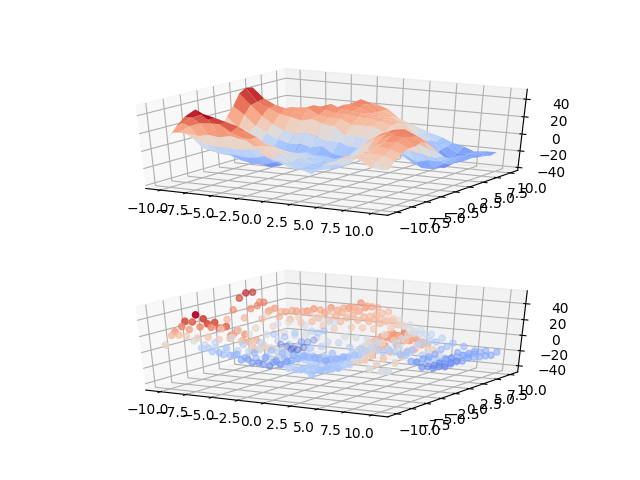

Environment initialized with bounds X1: ( -10.0 , 10.0 )  X2:( -10.0 , 10.0 )


<IPython.core.display.Javascript object>


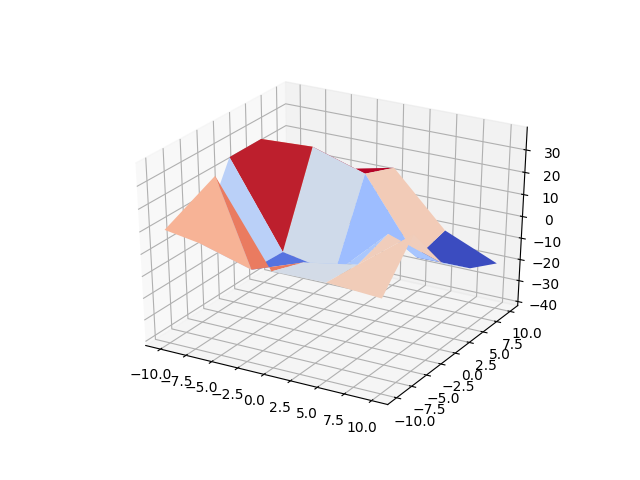

In [189]:
# x1min, x1max, x2min, x2max cosntrain the extent of the rectangular domain
ranges = (-10, 10, -10, 10)

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
world = Environment(ranges, NUM_PTS = 20, variance = 100.0, lengthscale = 3.0, visualize = True)

# Generate observations at random locations in environment and plot resulting predicted model
x1observe = np.linspace(ranges[0], ranges[1], 5)
x2observe = np.linspace(ranges[2], ranges[3], 5)
x1observe, x2observe= np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection = '3d')
surf = ax1.plot_surface(x1observe, x2observe, observations.reshape(x1observe.shape), cmap = cm.coolwarm, linewidth = 0)
plt.show()    

# Create the point robot
#obot = Robot([0, 0])

#robot.path_set([0,5], 3)